### Preparación de entorno

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

### Generación de datos de experimentación
El dataset sintético incluye cinco módulos representativos de un sistema hospitalario, caracterizados por líneas de código (LOC) como indicador de tamaño, complejidad ciclomática (CC) que mide la cantidad de caminos independientes en el código, churn que representa la frecuencia de cambios recientes (asociado a mayor riesgo de introducción de errores), uso diario como patrón de exposición del módulo, y defectos históricos acumulados. Adicionalmente, se incluye un historial granular de defectos por semana para capturar tendencias temporales, lo cual permite aplicar tanto modelos logarítmicos como estocásticos en la predicción de confiabilidad.

https://www.software.com/engineering-metrics/code-churn
https://en.wikipedia.org/wiki/Cyclomatic_complexity
https://www.geeksforgeeks.org/software-engineering/lines-of-code-loc-in-software-engineering/



In [12]:
# - loc: líneas de código
# - cc: complejidad ciclomática (proxy)
# - churn: cambios recientes (proxy de riesgo)
# - usage_day: llamadas/uso por día (patrón de uso)
# - defects_hist: defectos encontrados históricamente (acumulado)
modules = pd.DataFrame([
    {"modulo": "admision",      "loc": 120, "cc": 9,  "churn": 18, "usage_day": 220, "defects_hist": 6},
    {"modulo": "triage",        "loc": 95,  "cc": 7,  "churn": 10, "usage_day": 300, "defects_hist": 4},
    {"modulo": "facturacion",   "loc": 220, "cc": 14, "churn": 35, "usage_day": 90,  "defects_hist": 10},
    {"modulo": "reportes",      "loc": 180, "cc": 11, "churn": 22, "usage_day": 60,  "defects_hist": 7},
    {"modulo": "autenticacion", "loc": 80,  "cc": 6,  "churn": 8,  "usage_day": 500, "defects_hist": 3},
])
# datos historicos: defectos por semana en últimas 8 semanas
hist_defects = pd.DataFrame({
    "modulo": modules["modulo"],
    "w1": [1, 0, 2, 1, 0],
    "w2": [0, 1, 1, 1, 0],
    "w3": [1, 0, 2, 0, 0],
    "w4": [0, 1, 1, 1, 0],
    "w5": [1, 0, 1, 0, 0],
    "w6": [0, 0, 1, 1, 0],
    "w7": [0, 0, 1, 0, 0],
    "w8": [0, 0, 1, 0, 0],
})

### Features: logarítmicas mas normalización simple
Se calculan métricas históricas agregadas: la suma de defectos recientes (defects_recent_sum) como indicador de volumen de fallos, y la tendencia (defects_recent_trend) como diferencia entre la última y primera semana, permitiendo detectar si el módulo está mejorando o degradándose. Finalmente, se define la tasa histórica semanal como proxy del hazard rate actual, fundamental para los modelos de confiabilidad exponencial

https://pub.towardsai.net/data-scientists-dont-overlook-log1p-82b321fd5e9c

In [14]:
df = modules.merge(hist_defects, on="modulo")

# Métricas históricas resumidas (patrones históricos)
week_cols = [c for c in df.columns if c.startswith("w")]
df["defects_recent_sum"] = df[week_cols].sum(axis=1)
df["defects_recent_trend"] = df["w8"] - df["w1"]

# Enfoque logarítmico: log(1 + uso), log(1 + LOC), log(1 + churn)
df["log_usage"] = np.log1p(df["usage_day"])
df["log_loc"]   = np.log1p(df["loc"])
df["log_churn"] = np.log1p(df["churn"])

# Target histórico para ajustar un modelo simple:
# Usaremos tasa de defectos reciente (por semana) como proxy de "hazard" actual.
df["rate_hist_week"] = (df["defects_recent_sum"] + 1e-6) / len(week_cols)  # evitar cero exacto


### Modelo base (logarítmico): regresión lineal sobre log(tasa)

Para predecir la tasa de defectos de cada módulo se utilizo una regresión lineal pero aplicando logaritmos a los datos, se entreno el modelo con los datos transformados y después conviertoconvirtiendolos en predicciones de vuelta a valores normales.

https://pub.towardsai.net/data-scientists-dont-overlook-log1p-82b321fd5e9c


In [15]:
X = np.column_stack([
    np.ones(len(df)),
    df["log_usage"].values,
    df["cc"].values,
    df["log_loc"].values,
    df["log_churn"].values,
    df["defects_hist"].values,
    df["defects_recent_trend"].values,
])
y = np.log(df["rate_hist_week"].values + 1e-9)  # log-rate

beta, *_ = np.linalg.lstsq(X, y, rcond=None)

def predict_rate_week(row):
    x = np.array([
        1.0,
        np.log1p(row["usage_day"]),
        row["cc"],
        np.log1p(row["loc"]),
        np.log1p(row["churn"]),
        row["defects_hist"],
        row["defects_recent_trend"],
    ])
    log_rate = float(x @ beta)
    return float(np.exp(log_rate))  # tasa esperada de defectos por semana (modelo logarítmico)

df["rate_pred_week_log"] = df.apply(predict_rate_week, axis=1)

### Componente estocástico (Monte Carlo)

Se aplico la simulación Monte Carlo con 5000 iteraciones, en lugar de asumir que la tasa de defectos es fija, la hacemos variar aleatoriamente en cada simulación usando una distribución lognormal. Con modulos más complejos o con más cambios recientes tienen mayor variabilidad, lo cual tiene sentido intuitivamente. Luego, para cada tasa simulada, se genera defectos con una distribución Poisson y los acumulo en un aproximado de 4 semanas.

https://sparkco.ai/blog/build-customer-success-forecasting-model

In [16]:
HORIZON_WEEKS = 4           # predicción para próximas 4 semanas
N_SIM = 5000                # simulaciones Monte Carlo
EXPOSURE_PER_WEEK = df["usage_day"].values * 7  # usos/semana (aprox), deriva de patrón de uso

rates = df["rate_pred_week_log"].values  # defectos esperados por semana

# Jitter multiplicativo lognormal para representar incertidumbre (estocástico)
# (cuanto más churn y cc, más varianza)
sigma = 0.15 + 0.01 * df["cc"].values + 0.005 * df["churn"].values
sigma = np.clip(sigma, 0.15, 0.9)

sim_defects_total = np.zeros((len(df), N_SIM), dtype=float)
sim_reliability    = np.zeros((len(df), N_SIM), dtype=float)

for i in range(len(df)):
    # Tasa estocástica por semana (lognormal alrededor de rate)
    rate_samples_week = rates[i] * np.exp(np.random.normal(0, sigma[i], size=N_SIM))
    # Defectos por semana ~ Poisson(rate_samples_week), sumamos sobre horizonte
    defects = np.random.poisson(lam=rate_samples_week, size=(HORIZON_WEEKS, N_SIM)).sum(axis=0)
    sim_defects_total[i, :] = defects

    # Convertimos defectos esperados a "hazard" por uso (simple):
    # hazard_per_use ≈ (rate_samples_week / exposure_week)
    hazard_per_use = rate_samples_week / max(EXPOSURE_PER_WEEK[i], 1.0)

    # Confiabilidad (aprox) de que NO ocurra fallo en el próximo "exposure" del horizonte:
    # R ≈ exp(-hazard_per_use * exposure_horizon)
    exposure_horizon = EXPOSURE_PER_WEEK[i] * HORIZON_WEEKS
    sim_reliability[i, :] = np.exp(-hazard_per_use * exposure_horizon)

### Predicción integrada por módulo (outputs finales)

Se consolida todos los resultados de las simulaciones Monte Carlo en métricas, para cada módulo calculése calculo el promedio de defectos esperados junto con sus percentiles 5 y 95, lo que da un rango de incertidumbre realista. Lo mismo se hizo con la confiabilidad. Además, se construyo un score integrado de 0 a 100 que combina la confiabilidad esperada con penalizaciones por complejidad, churn e intensidad de uso.
https://sparkco.ai/blog/build-customer-success-forecasting-model

In [17]:
def q(x, p):  # cuantiles
    return np.quantile(x, p)

rows = []
for i, mod in enumerate(df["modulo"].values):
    defects = sim_defects_total[i, :]
    rel = sim_reliability[i, :]

    # Métricas de predicción
    defects_mean = defects.mean()
    defects_p05, defects_p95 = q(defects, 0.05), q(defects, 0.95)

    rel_mean = rel.mean()
    rel_p05, rel_p95 = q(rel, 0.05), q(rel, 0.95)

    # Score integrado (simple y defendible):
    # - base: confiabilidad esperada
    # - penalización suave por complejidad y churn (riesgo estructural)
    # - penalización por intensidad de uso (más exposición)
    risk_struct = 0.02 * df.loc[i, "cc"] + 0.01 * df.loc[i, "churn"]
    risk_usage  = 0.03 * np.log1p(df.loc[i, "usage_day"])
    score = (rel_mean - 0.01 * risk_struct - 0.01 * risk_usage)
    score = float(np.clip(score, 0.0, 1.0)) * 100.0

    rows.append({
        "modulo": mod,
        "rate_pred_week_log": df.loc[i, "rate_pred_week_log"],
        "defectos_pred_mean": defects_mean,
        "defectos_pred_p05": defects_p05,
        "defectos_pred_p95": defects_p95,
        "confiabilidad_mean": rel_mean,
        "confiabilidad_p05": rel_p05,
        "confiabilidad_p95": rel_p95,
        "score_integrado_0_100": score,
    })

out = pd.DataFrame(rows).sort_values(by="score_integrado_0_100", ascending=False)

print("PREDICCIÓN INTEGRADA POR MÓDULO (horizonte:", HORIZON_WEEKS, "semanas )\n")
display(out)

PREDICCIÓN INTEGRADA POR MÓDULO (horizonte: 4 semanas )



,modulo,rate_pred_week_log,defectos_pred_mean,defectos_pred_p05,defectos_pred_p95,confiabilidad_mean,confiabilidad_p05,confiabilidad_p95,score_integrado_0_100
4,autenticacion,1.260000e-07,0.0000,0.0,0.0,0.999999,0.999999,1.000000,99.613450
1,triage,2.500001e-01,1.0334,0.0,3.0,0.369761,0.210754,0.529858,36.564862
0,admision,3.750001e-01,1.5672,0.0,4.0,0.231216,0.075994,0.414492,22.599645
3,reportes,5.000001e-01,2.1414,0.0,5.0,0.156018,0.027543,0.339841,15.038493
2,facturacion,1.250000e+00,5.5764,1.0,13.0,0.022789,0.000020,0.101802,1.513593


### visualización: Confiabilidad por módulo
Se genero dos gráficos de barras para visualizar los resultados de forma intuitiva. El primero muestra la confiabilidad esperada por módulo y se ve claramente que autenticacion tiene una confiabilidad cercana a 1, mientras que facturacion está prácticamente en cero. El segundo gráfico presenta los defectos futuros esperados en el horizonte de 4 semanas, aquí la relación es inversa con facturacion liderando con más de 5 defectos proyectados.


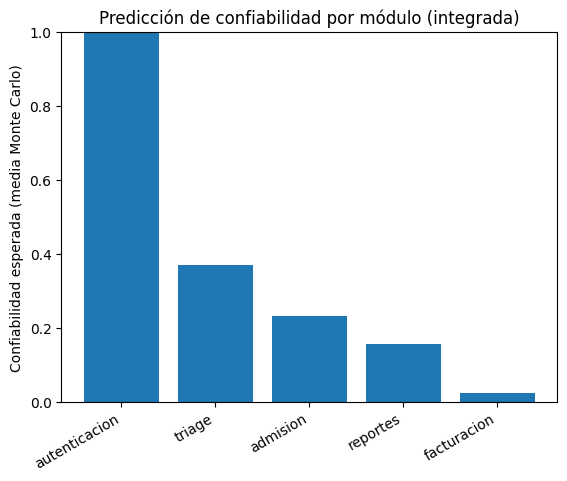

In [18]:
plt.figure()
plt.bar(out["modulo"], out["confiabilidad_mean"])
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.ylabel("Confiabilidad esperada (media Monte Carlo)")
plt.title("Predicción de confiabilidad por módulo (integrada)")
plt.show()

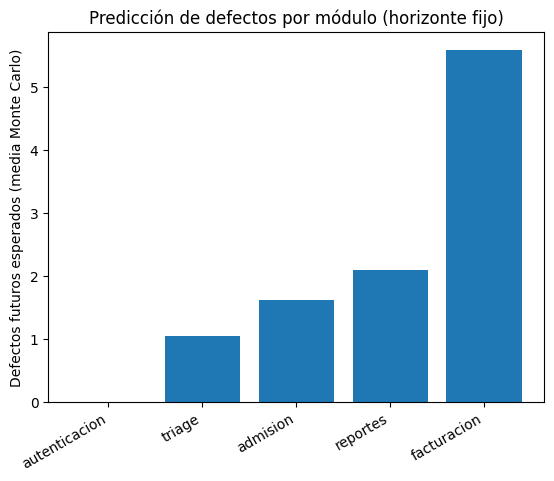

In [ ]:
plt.figure()
plt.bar(out["modulo"], out["defectos_pred_mean"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Defectos futuros esperados (media Monte Carlo)")
plt.title("Predicción de defectos por módulo (horizonte fijo)")
plt.show()